# Activity 1: Solid State Spis -- Cavity QED Digital Twin


## Prelab

 1. Setup [QuTiP](https://qutip.org/) to run on a cloud service like Google Colab or install it on your own PC.
 2. Go through and perform the activities in [QuTiP Lecture 0](https://qutip.org/qutip-tutorials/).
 3. Read the background text for the [NV Center Lab](chapter:NV-Centers) to understand the basics of the experimental setup.

## Cavity-coupled quantum electrodynamic (QED) sensor
 Hanfeng Wang, Matthew E. Trusheim, and Dirk Englund

Resonators for electromagnetic fields in the range of 1-100 GHz are essential in a range of quantum technologies, including superconducting quantum computers, microwave-optical quantum information interfaces, as well as sensors. Here, we consider microwave cavities coupled to ensembles of electron and nuclear spins associated with nitrogen vacancy (NV) centers in diamond. Following the discovery of coherent quantum dynamics of NV centers in the late 1990s, NV centers have emerged as leading quantum sensors for quantities ranging from electromagnetic fields to temperature, strain, rotation (gyroscopes), and have even been proposed for exotic schemes like dark matter detection. The key advantages of NV centers in sensing applications, over other electron spin systems, are their long coherence times and avaible optical polarization at room temperature.

Suggested reading for this laboratory on hybrid systems of microwave cavities coupled to NV spin ensembles specifically:
-- 1 ) [E. Eisenach et al, Cavity-enhanced microwave readout of a solid-state spin sensor](https://www.nature.com/articles/s41467-021-21256-7)

-- [optional] [JF Barry et. al. Sensitivity optimization for NV-diamond magnetometry](https://https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.92.015004)

-- [optional] [ D. Fahey et. al., Steady-state microwave mode cooling with a diamond NV ensemble](https://https://arxiv.org/abs/2203.03462)


-- [ME Trusheim et. al. A Polariton-Stabilized Spin Clock
](https://arxiv.org/abs/2009.02427)


Upon optical excitation, nonradiative decay through a spin-state-dependent intersystem crossing produces spin-state-dependent fluorescence contrast and polarize NV spin to m_s = 0 ground state. A common way for NV spin readout relies on detecting this spin-state-dependent fluorescence. However, due to the low photon detection efficiency (C~0.015) for NV ensemble, the NV magnetic sensitivity is limited by the photon-shot-noise-limit.

One way to solve this problem is to use NV-cavity coupling, where we couple NV centers to another system (cavity in this case) and read the NV resonance frequency by via the cavity mode.

In this module, you will learn how to simulate this system in QuTiP.

:::{figure-md} cavity-QED-setup
<img src="FIGURES/nv-center-cavity-qed-setup.png" alt="HOM-setup" class="bg-primary mb-1" width="800px">

Experimental setup for studying quantum spins.
:::

Linear Regime

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
%matplotlib inline

@widgets.interact_manual(
    g0_in=(0.01, 1.),kc0_in=(1., 1000.),kc1_in=(1., 1000.),ks_in=(1., 1000.))
def runFunc(g0_in=0.01, kc0_in = 70, kc1_in = 111, ks_in = 308):
    kc0 = 2*np.pi*kc0_in; #kHz  Cavity linewidth
    kc1 = 2*np.pi*kc1_in; #kHz   Cavity-loop coupling (output coupling)

    ks = 2*np.pi*ks_in; #kHz  Spin coherence time


    density_NVs = 5; #PPM Density of NV centers in the diamond, given in ppm
    diamondDensity = 1.76e29; # atoms/m^3 Atomic density of diamond
    density_NVs_SI = density_NVs*1e-6*diamondDensity; # NV/m^3

    diamond_sample_dim_x=3e-3; # m Diamond spatial dimensions, assuming cuboid
    diamond_sample_dim_y=3e-3; # m
    diamond_sample_dim_z=0.5e-3; # m
    diamond_sample_volume = diamond_sample_dim_x*diamond_sample_dim_y*diamond_sample_dim_z;

    N_NVs= density_NVs_SI*diamond_sample_volume ; # the number of NVs in the diamond

    g0 = g0_in*1e-3; #kHz   Coupling strength for single spin, see referenced papers

    geff = g0*np.sqrt(N_NVs); # Total coupling scales as sqrt(N)


    kc = kc0 + kc1; # Total cavity loss

    xnum = 101; # number of points to plot in x
    ynum = 121;

    # initialize sweep parameters
    wdc = np.linspace(-0.8,0.8,num=xnum)*1e3*2*np.pi;  #kHz  Detuning of the probe frequency and cavity frequency
    wsc = np.linspace(-7.4,7.4,num=ynum)*1e3*2*np.pi;  #kHz  Detuning of the spin frequency and cavity frequency

    # initialize output ararys
    inphaseOut = np.zeros((xnum,ynum));
    quadratureOut = np.zeros((xnum,ynum));

    for ii in range(xnum):

      for jj in range(ynum):

        wds = wdc[ii]-wsc[jj]; #spin-cavity detuning

        # Cavity reflection signal from references
        refOutput = -1 + kc1/(kc/2+1j*wdc[ii]+pow(geff,2)/(ks/2+1j*wds));
        inphaseOut[ii][jj] = np.real(refOutput); # In-phase part of the cavity signal
        quadratureOut[ii][jj] = np.imag(refOutput);  # Quadrature part of the cavity signal

    y, x = np.meshgrid(np.linspace(-7.4,7.4,num=ynum), np.linspace(-0.8,0.8,num=xnum),)
    fig, figAxes = plt.subplots(2,2,sharex='all', sharey='all')
    ax1 = figAxes[0,0];
    ax2 = figAxes[0,1];
    ax3 = figAxes[1,0];
    ax4 = figAxes[1,1];


    c = ax1.pcolormesh(y, x, quadratureOut)
    ax1.set_title('Q')
    #ax1.set_xlabel('fsc (MHz)')
    ax1.set_ylabel('fdc (MHz)')
    fig.colorbar(c, ax=ax1)

    c = ax2.pcolormesh(y, x, inphaseOut)
    ax2.set_title('I')
    #ax2.set_xlabel('fsc (MHz)')
    #ax2.set_ylabel('fdc (MHz)')
    fig.colorbar(c, ax=ax2)

    c = ax3.pcolormesh(y, x, np.sqrt(pow(quadratureOut,2)+pow(inphaseOut,2)))
    ax3.set_title('P')
    ax3.set_xlabel('fsc (MHz)')
    ax3.set_ylabel('fdc (MHz)')
    fig.colorbar(c, ax=ax3)

    c = ax4.pcolormesh(y, x, np.arctan( np.divide(quadratureOut,inphaseOut)))
    ax4.set_title('Phi')
    ax4.set_xlabel('fsc (MHz)')
    #ax4.set_ylabel('fdc (MHz)')
    fig.colorbar(c, ax=ax4)

    plt.show()


interactive(children=(FloatSlider(value=0.01, description='g0_in', max=1.0, min=0.01), FloatSlider(value=70.0,…

Nonlinear Regime

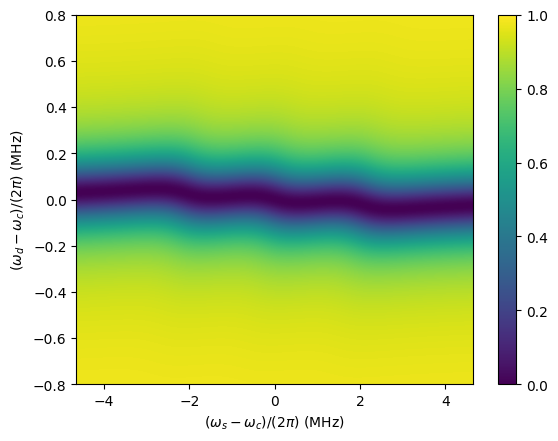

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and Parameters
Gamma = 330e3  # Inhomogeneous linewidth
gammao = 33e3  # Optical polarization rate
gamma = 2e3    # Homogeneous linewidth

kc1 = 130e3 # Intrinsic cavity linewidth
kc = kc1 + 130e3  # Total cavity linewidth
gs = 0.019 # Single spin coupling strength
Power = -10  # Input MW power
alpha2 = 10**(Power/10) * 1e-3 / (6.626e-34 * 2.87e9 * kc1)

geff = 0.2e6  # Total coupling strength

omega = 0

wdc = np.linspace(-0.8, 0.8, 1001) * 1e6
wsc = np.linspace(-4.65, 4.65, 1001) * 1e6

# Initialize array for results
ref = np.zeros((len(wdc), len(wsc)), dtype=complex)

# Main calculation loop
for ii in range(len(wdc)):
    for jj in range(len(wsc)):
        wds = wdc[ii] - wsc[jj]
        integ1 = 2 * ((gamma + gammao) + (gamma + gammao) * Gamma / np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2) - 2j * wds) / \
                ((Gamma + np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2))**2 + 4 * wds**2)
        integ2 = 2 * ((gamma + gammao) + (gamma + gammao) * Gamma / np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2) - 2j * (wds + 2.1e6)) / \
                ((Gamma + np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2))**2 + 4 * (wds + 2.1e6)**2)
        integ3 = 2 * ((gamma + gammao) + (gamma + gammao) * Gamma / np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2) - 2j * (wds - 2.1e6)) / \
                ((Gamma + np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2))**2 + 4 * (wds - 2.1e6)**2)
        integ = integ1 + integ2 + integ3
        ref[ii, jj] = -1 + kc1 / (kc / 2 + 1j * wdc[ii] + geff**2 * integ)

# Plotting
plt.figure(10)
plt.imshow(np.abs(ref)**2, extent=[wsc[0] / 1e6, wsc[-1] / 1e6, wdc[0] / 1e6, wdc[-1] / 1e6], aspect='auto', origin='lower')
plt.colorbar()
plt.clim(0, 1)

plt.xlabel(r'$(\omega_s-\omega_c)/(2\pi)$ (MHz)')
plt.ylabel(r'$(\omega_d-\omega_c)/(2\pi)$ (MHz)')

plt.show()

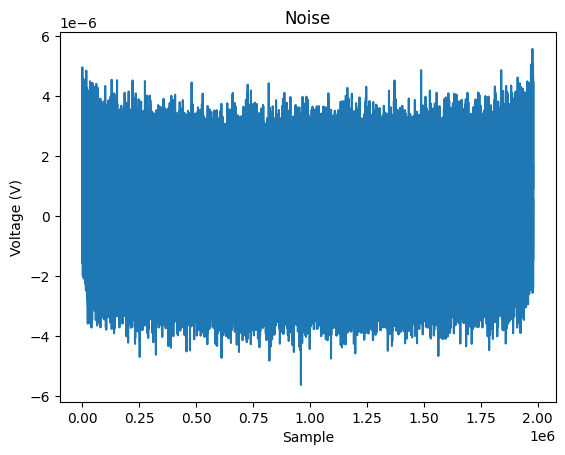

In [ ]:
length = 2000000  # Length of the signal
fs = 200e3      # Sampling frequency in Hz

white_noise = np.random.randn(length)*1e-6
t = np.arange(length) / fs
sine_wave = 0
for ii in range(10):
    sine_wave = sine_wave + 1e-7* np.sin(2 * np.pi * 60 * t * (ii+1)) * 1/2**ii
#    sine_wave = 1e-7* np.sin(2 * np.pi * 60 * t) +  0.5e-7* np.sin(2 * np.pi * 120 * t) +  0.25e-7* np.sin(2 * np.pi * 180 * t);

fft_result1 = np.fft.fft(white_noise+sine_wave)

frequencies = np.fft.fftfreq(length, d=1/fs)
frequencies[0] = 1e-6  # Avoid division by zero

scale_factor = 1 / np.sqrt(np.abs(frequencies))
fft_result2 = scale_factor

modified_fft = (fft_result1 + fft_result2*1e-1);

flicker_noise = np.fft.ifft(modified_fft).real

final = flicker_noise - np.mean(flicker_noise)



plt.plot(final[10000:2000000-10000])
plt.title('Noise')
plt.xlabel('Sample')
plt.ylabel('Voltage (V)')
plt.show()




(10.0, 100000.0)

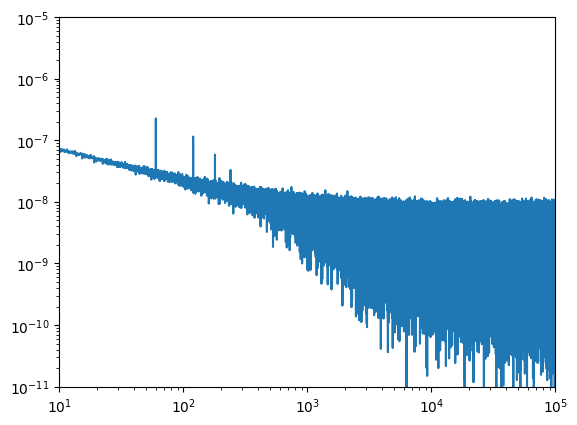

In [ ]:
from scipy.signal import periodogram
frequencies, psd = periodogram(final, fs)
plt.plot(frequencies, np.sqrt(psd))
plt.xscale("log")
plt.yscale("log")
plt.ylim([1e-11,1e-5])
plt.xlim([1e1,1e5])

# Exercise 1:

Now we have the signal and noise model. Could you combine two previous codes and generate two plots, one with noise model and a perfect one generated in Sec. I?



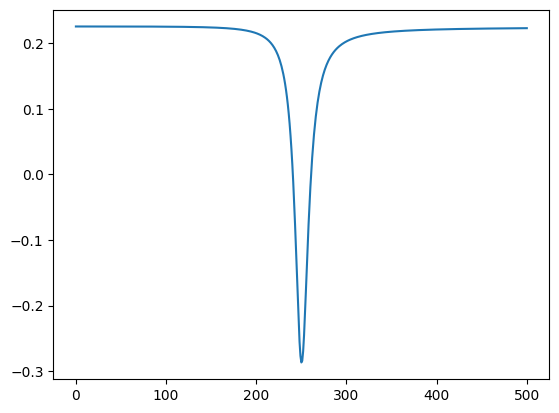

In [ ]:
# Part 1
# Let's consider a 1D plot first.

g0_in=0.01
kc0_in = 70
kc1_in = 111
ks_in = 308
kc0 = 2*np.pi*kc0_in; #kHz  Cavity linewidth
kc1 = 2*np.pi*kc1_in; #kHz   Cavity-loop coupling (output coupling)

ks = 2*np.pi*ks_in; #kHz  Spin coherence time

density_NVs = 5; #PPM Density of NV centers in the diamond, given in ppm
diamondDensity = 1.76e29; # atoms/m^3 Atomic density of diamond
density_NVs_SI = density_NVs*1e-6*diamondDensity; # NV/m^3

diamond_sample_dim_x=3e-3; # m Diamond spatial dimensions, assuming cuboid
diamond_sample_dim_y=3e-3; # m
diamond_sample_dim_z=0.5e-3; # m
diamond_sample_volume = diamond_sample_dim_x*diamond_sample_dim_y*diamond_sample_dim_z;

N_NVs= density_NVs_SI*diamond_sample_volume ; # the number of NVs in the diamond

g0 = g0_in*1e-3; #kHz   Coupling strength for single spin, see referenced papers

geff = g0*np.sqrt(N_NVs); # Total coupling scales as sqrt(N)


kc = kc0 + kc1; # Total cavity loss

xnum = 501; # number of points to plot in x
ynum = 501;

# initialize sweep parameters
wdc = np.linspace(-0.8,0.8,num=xnum)*1e3*2*np.pi;  #kHz  Detuning of the probe frequency and cavity frequency
wsc = np.linspace(-7.4,7.4,num=ynum)*1e3*2*np.pi;  #kHz  Detuning of the spin frequency and cavity frequency

# initialize output ararys
inphaseOut = np.zeros((xnum,ynum));
quadratureOut = np.zeros((xnum,ynum));

for ii in range(xnum):

  for jj in range(ynum):

    wds = wdc[ii]-wsc[jj]; #spin-cavity detuning

    # Cavity reflection signal from references
    refOutput = -1 + kc1/(kc/2+1j*wdc[ii]+pow(geff,2)/(ks/2+1j*wds));
    inphaseOut[ii][jj] = np.real(refOutput); # In-phase part of the cavity signal
    quadratureOut[ii][jj] = np.imag(refOutput);  # Quadrature part of the cavity signal

plt.plot(inphaseOut[251][:])

# Part 2
# Now you have a perfect signal, could you add noise here?
## Please add your code here


# Exercise 2:
Now assume we have a test field $B_t$, could you generate a $B_t$ in the digital twin? Decrease the amplitude and see what is the minimum test field $B_t$ you can measure in the digital twin.


In [ ]:
## Please add your code here

## Minimum detectable magnetic field



Here is the sensitivity analysis for cavity-coupled sensor. In the ideal case, the spin-projection-limit sensitivity is propotional to the inverse of the square root of the number of spins (N). However, the NV decoherence time and dephasing time will decrease during the increase of the NV number. Therefore, the sensivitity will decrease sharply in the large-N regime. The script below calculated the spin-projection-limit sensitivity and photon-shot-noise-limit with different number of spins.

The script below also include the cavity-coupled spin sensor. The scale of the sensitivity in the low-N regime is linear with the 1/N rather than 1/sqrt(N), which offers the possibility for this sensor to go below the spin-projection-limit sensitivity.

[[ choose here parameters that students can actually modify in the laboratory: i.e., microwave driving power, optical pump power; bias point of microwave readout signal [\omega_probe] ]]

Text(0, 0.5, 'Sensitivity (T/\\sqrt(Hz))')

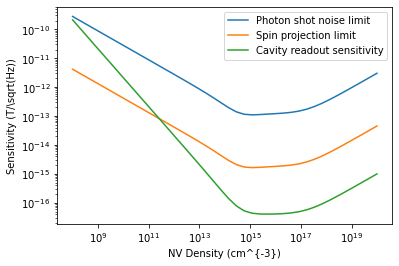

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Delta = 2e6;
f = 0.1;

Sphi = 1e-9; # phase noise

Q = 3e4;  # Quality factor

hbar = 1.05e-34;

gs = 2;

muB = 9.27e-24;

rho = np.logspace(8,20,40)*1e6;

Tc = 1/3.3e-19/(rho*(0.95/0.05));

T2c = 300e-6;

T2 = 1/(1/T2c+1/Tc);

mu0 = 4*np.pi*1e-7;

C = 0.015;

etaB = 8 * pow((hbar/gs/muB),3) * Delta/np.pi/Q/T2 * Sphi * 1/mu0/hbar/rho *1/f * np.exp(pow((T2/T2c),3))* np.exp(T2/Tc)* np.sqrt(1+1e-6/T2);

eta = hbar/muB/gs * np.pi * np.exp(pow((T2/T2c),3))/C/np.sqrt(rho*T2) * np.exp(T2/Tc) * np.sqrt(1+1e-6/T2);

eta_proj = hbar/muB/gs * np.pi * np.exp(pow((T2/T2c),3))/np.sqrt(rho*T2) * np.exp(T2/Tc) * np.sqrt(1+1e-6/T2);

fig,ax = plt.subplots()

ax.loglog(rho/1e6,eta*1/np.sqrt(3e-3*3e-3*0.5e-3),label='Photon shot noise limit')

ax.loglog(rho/1e6,eta_proj*1/np.sqrt(3e-3*3e-3*0.5e-3),label='Spin projection limit')

ax.loglog(rho/1e6,etaB,label='Cavity readout sensitivity')

ax.legend()

ax.set_xlabel('NV Density (cm^{-3})')
ax.set_ylabel('Sensitivity (T/\sqrt(Hz))')




## Lab aims


**Aim 1: Characterizatin of the NV-cavity QED apparatus**



**A1.1: Test the cavity Q and frequency with digital twin**

Put numbers into Digital Twin based on [E. Eisenach et al, Cavity-enhanced microwave readout of a solid-state spin sensor](https://www.nature.com/articles/s41467-021-21256-7). Reproduce curves in the publication.


**A1.2: Cavity Experiment**

1. Find cavity resonance frequency. Connect vector network analyzer (VNA) to the cavity and detect S12 reflection signal. Move the position of the loop to critical couple the loop and the cavity. Get the cavity resonance frequency based on the VNA signal.

2. Analysis the cavity resonance signal. Disconnect the VNA and connect the signal generator (SG) to the circuit. Sweep the frequency near the cavity resonance frequency. Compare the experimental data and simulations from Digital Twin by setting N=0. Get the cavity linewidth κc with the model.

3. NV-cavity coupling. Turn on the laser and set the power to 8 W. Set the microwave power to -17 dBm and sweep the SG frequency and the voltage (current) in the Helmholtz coil. Use the Digital Twin to check your data and get the coupling strength g_{eff} and spin linewidth κs.


**A1.3: Power dependence**

Set laser power to be 8 W, and microwave power to be P_opt=[-30,-25,-20,-15,-10,-5,0,5,10] dBm. Plot the refection signal for each microwave power. Compare your result with [E. Eisenach et al, Cavity-enhanced microwave readout of a solid-state spin sensor](https://www.nature.com/articles/s41467-021-21256-7).

**Aim 2: Magnetic field sensitivity**

Now think about how we can make use of the NV-cavity coupling system. A straightforward thing mentioned before is the magnetometry.

**A2.1 Sensitivity calculation**

Based on your understanding on the project, write codes to calculate the maximum senstivity you can achieve using the parameters you get from Digital Twin and experiments.

**A2.2 Power depedence**

Think about how this power dependence is related to the magnetic field sensitivity. Calculated it from the Digital Twin model and compare with the experiment data.

